In [2]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_pendulum import get_pendulum_data, pendulum_to_movie
from scipy.integrate import odeint
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_resource_variables()

In [3]:
data_path = os.getcwd() + '/noise/'
#save_name = 'model1'
save_name = 'pendulum_2024_06_02_10_16_01_563302'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.compat.v1.train.Saver(var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [4]:
t = np.arange(0, 20, .02)
z0s = np.pi/np.array([1.5,2,3,4,8,16])
dz0s = .5*np.ones(z0s.shape)

f  = lambda z, t : [z[1], -np.sin(z[0])]
n_ics = z0s.size

z = np.zeros((n_ics,t.size,2))
dz = np.zeros(z.shape)
for i in range(n_ics):
    z[i] = odeint(f, [z0s[i],dz0s[i]], t)
    dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
    
x,dx,ddx = pendulum_to_movie(z,dz)

In [5]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
test_data['z'] = z[:,:,0].reshape((-1,params['latent_dim']))
test_data['dz'] = z[:,:,1].reshape((-1,params['latent_dim']))
test_data['ddz'] = dz[:,:,1].reshape((-1,params['latent_dim']))

In [6]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/timotheusberg/Documents/COSSE/Semester 2/Special Topics/SindyAutoencoders/examples/pendulum/noise/pendulum_2024_06_02_10_16_01_563302


2024-06-04 19:09:27.384881: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-04 19:09:27.384910: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-04 19:09:27.384919: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-04 19:09:27.385007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-04 19:09:27.385076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-04 19:09:27.391910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-06-04 19:09:27.397332: I tensorflow/core/grapple

In [7]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)
true_coefficients[-2] = -1.

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    pendulum_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

([], [])

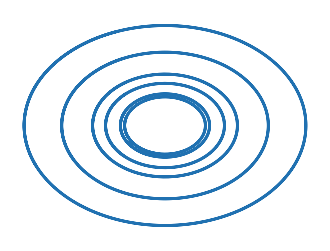

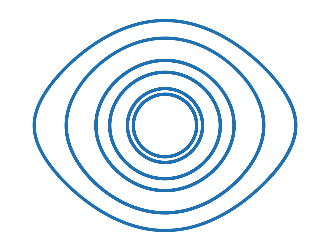

In [8]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,:,0].T, pendulum_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

/var/folders/wr/8yf6sp0x3n5grvx_v1qn9sgh0000gn/T/ipykernel_28081/3619258448.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -0.796336256525157, 1.3019254868273091)

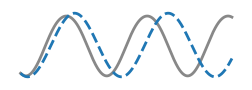

In [9]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

## Test set analysis - in distribution

In [10]:
test_data = get_pendulum_data(10)

Generating pendulum data


In [11]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/timotheusberg/Documents/COSSE/Semester 2/Special Topics/SindyAutoencoders/examples/pendulum/noise/pendulum_2024_06_02_10_16_01_563302


2024-06-04 19:09:29.701503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-04 19:09:29.701526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-04 19:09:29.710453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-04 19:09:29.797273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-04 19:09:30.001336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy reltive error, z: %f' % sindy_ddz_error)

Decoder relative error: 0.002303
Decoder relative SINDy error: 0.001295
SINDy reltive error, z: 0.280122
